In [1]:
import os
import networkx as nx
import pandas as pd
import graspologic

data_dir = os.path.expanduser("~/Documents/Neural Data Design/cora")

In [2]:
edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["target", "source"])
edgelist["label"] = "cites"

In [3]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")
nx.set_node_attributes(Gnx, "paper", "label")

In [4]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None, names=column_names)
Y = node_data.to_numpy()[:, 0:1433]
labels = node_data["subject"].to_numpy()

In [5]:
A = graspologic.utils.import_graph(Gnx)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_latents(latent_positions, *, title, labels, ax=None):
    if ax is None:
        ax = plt.gca()
    plot = sns.scatterplot(latent_positions[:, 0], latent_positions[:, 1], hue=labels, 
                           linewidth=0, s=10, ax=ax, palette="Set1")
    plot.set_title(title, wrap=True);
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.legend(bbox_to_anchor=(1.5, 1), loc="upper right", title="Community")
    
    return plot

/Users/ze/opt/miniconda3/envs/Stellar/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


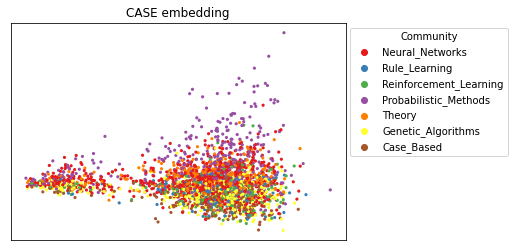

In [7]:
from graspologic.embed import CovariateAssistedEmbed as CASE

case = CASE(alpha=0.5, assortative=False, n_components=16)
latents = case.fit_transform((A, Y))
plot_latents(latents, title=r"CASE embedding", labels=labels);

## Train a classifier on CASE latent positions

In [27]:
from tensorflow.keras import layers, optimizers, losses, metrics, Model, Sequential, utils
from sklearn import preprocessing, model_selection

node_subjects = pd.Series(labels)
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.1, test_size=None, stratify=node_subjects
)

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
test_targets = target_encoding.transform(test_subjects)


train_data = latents[train_subjects.index.values, :]
test_data = latents[test_subjects.index.values, :]

## Create Keras model

In [44]:
model = Sequential(
    layers.Dense(units=train_targets.shape[1], activation="softmax")
)

In [45]:
model.compile(
    optimizer=optimizers.Adam(lr=0.03),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

## Train the model

In [46]:
model.fit(train_data, train_targets, epochs=100)

Epoch 1/100
9/9 [==============================] - 0s 652us/step - loss: 1.9188 - acc: 0.2169
Epoch 2/100
9/9 [==============================] - 0s 610us/step - loss: 1.8403 - acc: 0.2908
Epoch 3/100
9/9 [==============================] - 0s 633us/step - loss: 1.7789 - acc: 0.3087
Epoch 4/100
9/9 [==============================] - 0s 631us/step - loss: 1.7342 - acc: 0.3294
Epoch 5/100
9/9 [==============================] - 0s 713us/step - loss: 1.7520 - acc: 0.2959
Epoch 6/100
9/9 [==============================] - 0s 683us/step - loss: 1.7017 - acc: 0.2969
Epoch 7/100
9/9 [==============================] - 0s 757us/step - loss: 1.6912 - acc: 0.3010
Epoch 8/100
9/9 [==============================] - 0s 662us/step - loss: 1.6324 - acc: 0.3213
Epoch 9/100
9/9 [==============================] - 0s 683us/step - loss: 1.6493 - acc: 0.3110
Epoch 10/100
9/9 [==============================] - 0s 669us/step - loss: 1.5942 - acc: 0.3274
Epoch 11/100
9/9 [==============================] - 0s 662u

## Evaluate the model

In [47]:
test_loss, test_acc = model.evaluate(test_data,  test_targets, verbose=2)

print('\nTest accuracy:', test_acc)

77/77 - 0s - loss: 1.0531 - acc: 0.6665

Test accuracy: 0.6665299534797668


## Make prediction for all the nodes

In [48]:
all_predictions = model.predict(latents)

In [49]:
node_predictions = target_encoding.inverse_transform(all_predictions)

/Users/ze/opt/miniconda3/envs/Stellar/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


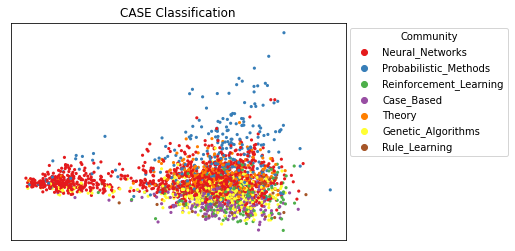

In [56]:
plot_latents(latents, title=r"CASE Classification", labels=node_predictions);

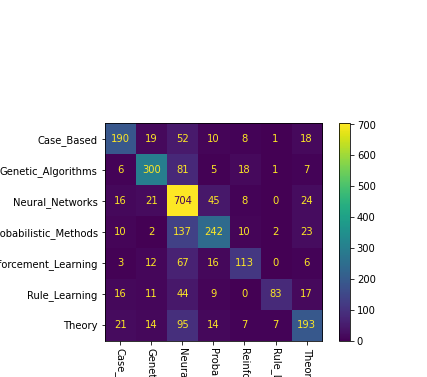

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

cm = confusion_matrix(labels, node_predictions, labels=['Case_Based', 'Genetic_Algorithms', 'Neural_Networks',
       'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning',
       'Theory'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Case_Based', 'Genetic_Algorithms', 'Neural_Networks',
       'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning',
       'Theory'])
disp.plot(xticks_rotation=270)

In [52]:
np.unique(labels)

array(['Case_Based', 'Genetic_Algorithms', 'Neural_Networks',
       'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning',
       'Theory'], dtype=object)